In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn_rvm import EMRVR


#feature importance
from sklearn.inspection import permutation_importance
import shap

import warnings
warnings.filterwarnings("ignore")

#Set random seed to current date and time to get a pseudorandom state
import random
from datetime import datetime
random.seed(datetime.now()) 

#This is to round the output to 3 decimal places when printing outputs
np.set_printoptions(precision=3)

#Import dataset
data = pd.read_csv("C:/Users/kimng/Desktop/ML - Age, Hipp, CVLT/CVLTHippocampus.csv")
data = data.reset_index(drop=True)

In [2]:
#Select columns to be used for analyses
columns = ['CVLT_Imm_Total', 'CVLT_DelR_SD_Free', 'CVLT_DelR_LD_Free',
            'Age','Sex', 'EduYears', 'Smoker', 'High_BP', 'COMT', 'BDNF2', 'ApoE4',
           'L_HH_Total', 'R_HH_Total', 'L_HB_Total', 'R_HB_Total', 'L_HT_Total', 'R_HT_Total',
           'L_DG_Total', 'R_DG_Total',
           'L_CA_Total', 'R_CA_Total',
           'L_Sub_Total', 'R_Sub_Total',
           'L_HH_CA', 'R_HH_CA', 'L_HB_CA', 'R_HB_CA', 'L_HT_CA', 'R_HT_CA', 
           'L_HH_DG', 'R_HH_DG', 'L_HB_DG', 'R_HB_DG', 'L_HT_DG', 'R_HT_DG',
           'L_HH_Sub', 'R_HH_Sub', 'L_HB_Sub', 'R_HB_Sub', 'L_HT_Sub', 'R_HT_Sub']

#Subset data
df = data[columns]

In [3]:
# drop missing data list-wise
df.dropna(inplace=True)

#reset index -- this is to replace old data index with index based on current data.
df = df.reset_index(drop=True)

# get new data dimension
df.shape 

(129, 41)

In [4]:
df.Sex = df.Sex-1 #Change Sex from 1,2 to 0,1

In [5]:
#Bin Age into groups
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = [1,2,3,4,5,6,7,8]
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
df = df.reset_index(drop=True)

#Function for categorise dataframe
def categorise(row):
    if row['AgeGroup'] == 1 and row['Sex'] == 0:
        return 1
    elif row['AgeGroup'] == 1 and row['Sex'] == 1:
        return 2
    elif row['AgeGroup'] == 2 and row['Sex'] == 0:
        return 3
    elif row['AgeGroup'] == 2 and row['Sex'] == 1:
        return 4
    elif row['AgeGroup'] == 3 and row['Sex'] == 0:
        return 5
    elif row['AgeGroup'] == 3 and row['Sex'] == 1:
        return 6
    elif row['AgeGroup'] == 4 and row['Sex'] == 0:
        return 7
    elif row['AgeGroup'] == 4 and row['Sex'] == 1:
        return 8
    elif row['AgeGroup'] == 5 and row['Sex'] == 0:
        return 9
    elif row['AgeGroup'] == 5 and row['Sex'] == 1:
        return 10
    elif row['AgeGroup'] == 6 and row['Sex'] == 0:
        return 11
    elif row['AgeGroup'] == 6 and row['Sex'] == 1:
        return 12
    elif row['AgeGroup'] == 7 and row['Sex'] == 0:
        return 13
    elif row['AgeGroup'] == 7 and row['Sex'] == 1:
        return 14
    elif row['AgeGroup'] == 8 and row['Sex'] == 0:
        return 15
    elif row['AgeGroup'] == 8 and row['Sex'] == 1:
        return 16


#Apply categories to dataframe
df['grp'] = df.apply(lambda row: categorise(row), axis=1)

In [6]:
df.describe()

,CVLT_Imm_Total,CVLT_DelR_SD_Free,CVLT_DelR_LD_Free,Age,Sex,EduYears,Smoker,High_BP,COMT,BDNF2,...,R_HB_DG,L_HT_DG,R_HT_DG,L_HH_Sub,R_HH_Sub,L_HB_Sub,R_HB_Sub,L_HT_Sub,R_HT_Sub,grp
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,54.775194,11.666667,12.248062,47.635659,0.542636,15.860465,1.031008,1.116279,2.062016,1.666667,...,312.167117,215.278658,216.086355,270.114788,286.853054,216.401042,208.797596,26.868606,29.594662,8.054264
std,9.126062,2.608080,2.613161,18.883251,0.500121,2.461403,0.174014,0.321809,0.736885,0.473242,...,56.639130,55.946779,57.863672,54.831992,53.460985,41.213681,35.336911,6.789627,8.055470,3.863511
min,35.000000,6.000000,5.000000,18.000000,0.000000,10.000000,1.000000,1.000000,1.000000,1.000000,...,173.639405,89.231806,89.795907,148.819290,158.846793,110.909966,106.781205,12.233782,15.553328,1.000000
25%,49.000000,10.000000,10.000000,30.000000,0.000000,14.000000,1.000000,1.000000,2.000000,1.000000,...,271.435985,174.712057,181.698029,229.770510,254.843688,186.129439,187.518921,22.200925,24.290453,4.000000
50%,55.000000,12.000000,12.000000,48.000000,1.000000,16.000000,1.000000,1.000000,2.000000,2.000000,...,313.215662,213.735190,209.295573,265.785139,285.320587,215.537167,209.140882,24.817369,28.900795,8.000000
75%,61.000000,14.000000,14.000000,64.000000,1.000000,17.000000,1.000000,1.000000,3.000000,2.000000,...,349.277249,254.920021,254.615139,310.839873,317.390520,243.406118,230.304132,31.469792,33.466886,11.000000
max,73.000000,16.000000,16.000000,85.000000,1.000000,23.000000,2.000000,2.000000,3.000000,2.000000,...,455.998451,352.813403,363.037216,433.877967,494.619458,332.358149,305.395180,46.911832,55.632057,16.000000


In [7]:
#Initialize Regressor
model = EMRVR()

#Set up parameter grid
param_grid = [{
                'gamma': ['scale', 'auto'], 
                'kernel': ['linear', 'poly', 'rbf'], 
                'degree': [1,2,3,4,5,6]}]

#Set up GridSearchCV
search = GridSearchCV(estimator=model, 
                      param_grid = param_grid,
                      scoring = 'neg_mean_squared_error', #use MSE for model selection (larger neg-MSE = better model)
                      cv = 3, 
                      n_jobs = 1, 
                      refit = True)

# Predicting Immediate Recall Performance


 Results for outer loop fold  1


<IPython.core.display.Javascript object>


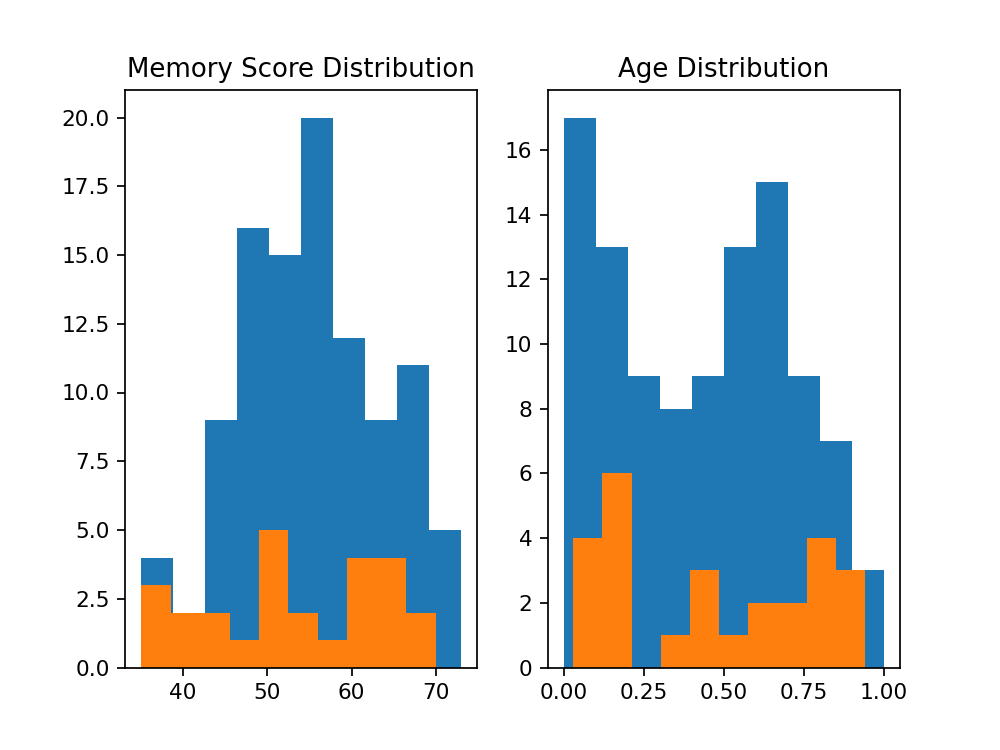

        Best MSE (across all inner validation folds): 62.94202893510055
        Best parameters: {'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}

        MSE (on outer training set) 47.040048400735635
        RMSE (on outer training set) 6.8585748082772735
        MAE (on outer training set) 5.693766818425775
        R2 (on outer training set) 0.3706328461774918
        Correlation between Predicted and actual values (on outer test set) 0.6106243013340291

        MSE (on outer test set) 78.42037175944469
        RMSE (on outer test set) 8.855527751604908
        MAE (on outer test set) 7.7682684001215225
        R2 (on outer test set) 0.2858293751851081
        Correlation between Predicted and actual values (on outer test set) 0.5725463179300909

 Results for outer loop fold  2


<IPython.core.display.Javascript object>


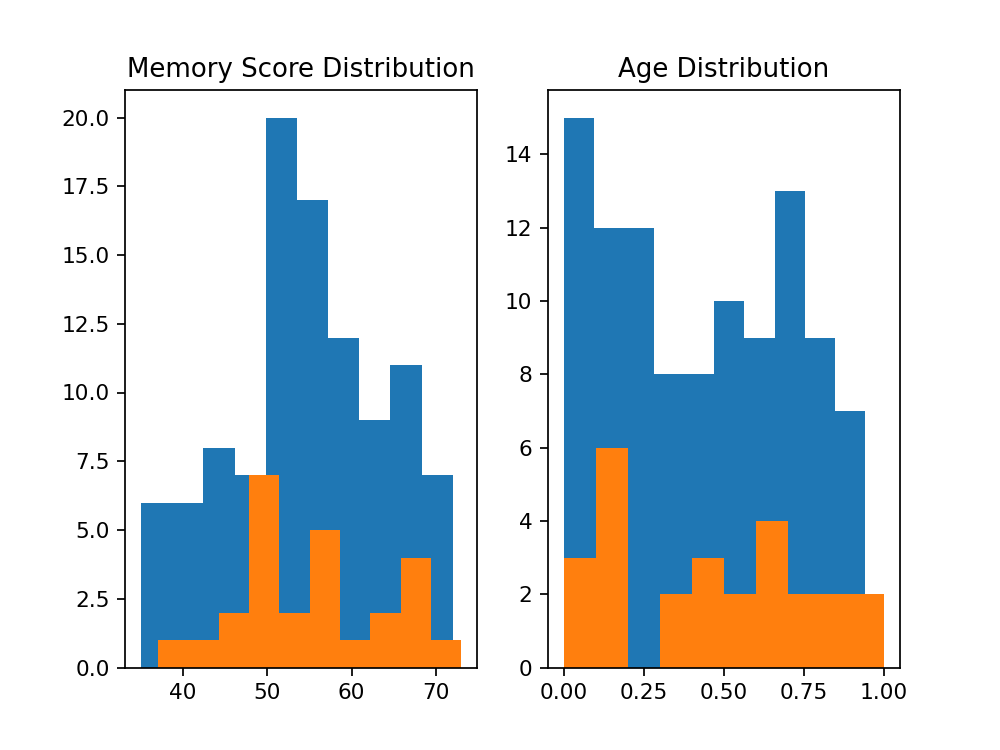

        Best MSE (across all inner validation folds): 67.12999213475985
        Best parameters: {'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}

        MSE (on outer training set) 49.680374257035645
        RMSE (on outer training set) 7.0484306236945855
        MAE (on outer training set) 5.987238567361109
        R2 (on outer training set) 0.4082322944394766
        Correlation between Predicted and actual values (on outer test set) 0.6407937605613568

        MSE (on outer test set) 70.50806729663334
        RMSE (on outer test set) 8.39690819865463
        MAE (on outer test set) 6.55078524645468
        R2 (on outer test set) 0.08641697668243231
        Correlation between Predicted and actual values (on outer test set) 0.4576022277709183

 Results for outer loop fold  3


<IPython.core.display.Javascript object>


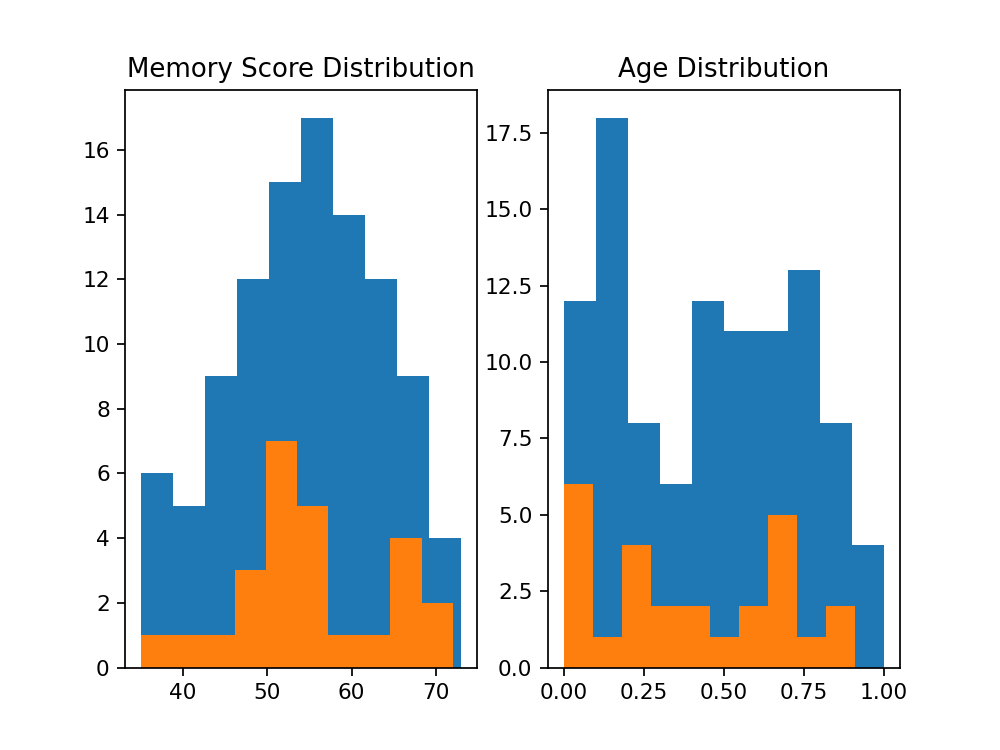

        Best MSE (across all inner validation folds): 66.85500733631297
        Best parameters: {'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}

        MSE (on outer training set) 50.59883625345759
        RMSE (on outer training set) 7.1132858970701855
        MAE (on outer training set) 5.787690649432169
        R2 (on outer training set) 0.38476987015493946
        Correlation between Predicted and actual values (on outer test set) 0.6229175613684589

        MSE (on outer test set) 69.4255270740918
        RMSE (on outer test set) 8.332198213802394
        MAE (on outer test set) 6.829166549432179
        R2 (on outer test set) 0.17298131560431995
        Correlation between Predicted and actual values (on outer test set) 0.43859626695378207

 Results for outer loop fold  4


<IPython.core.display.Javascript object>


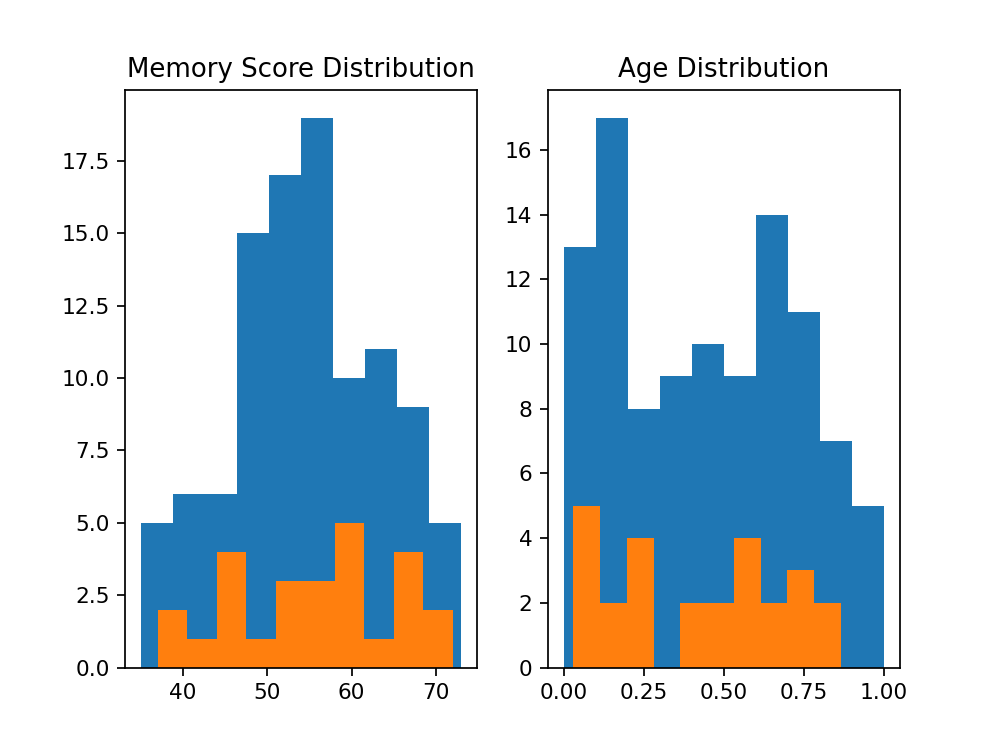

        Best MSE (across all inner validation folds): 57.021921939039714
        Best parameters: {'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}

        MSE (on outer training set) 43.5901481621555
        RMSE (on outer training set) 6.602283556630653
        MAE (on outer training set) 5.575810200301778
        R2 (on outer training set) 0.45997164461276163
        Correlation between Predicted and actual values (on outer test set) 0.6801504653160675

        MSE (on outer test set) 77.77514312052902
        RMSE (on outer test set) 8.819021664591205
        MAE (on outer test set) 7.2915410257270645
        R2 (on outer test set) 0.13430924292431423
        Correlation between Predicted and actual values (on outer test set) 0.3784948620047545

 Results for outer loop fold  5


<IPython.core.display.Javascript object>


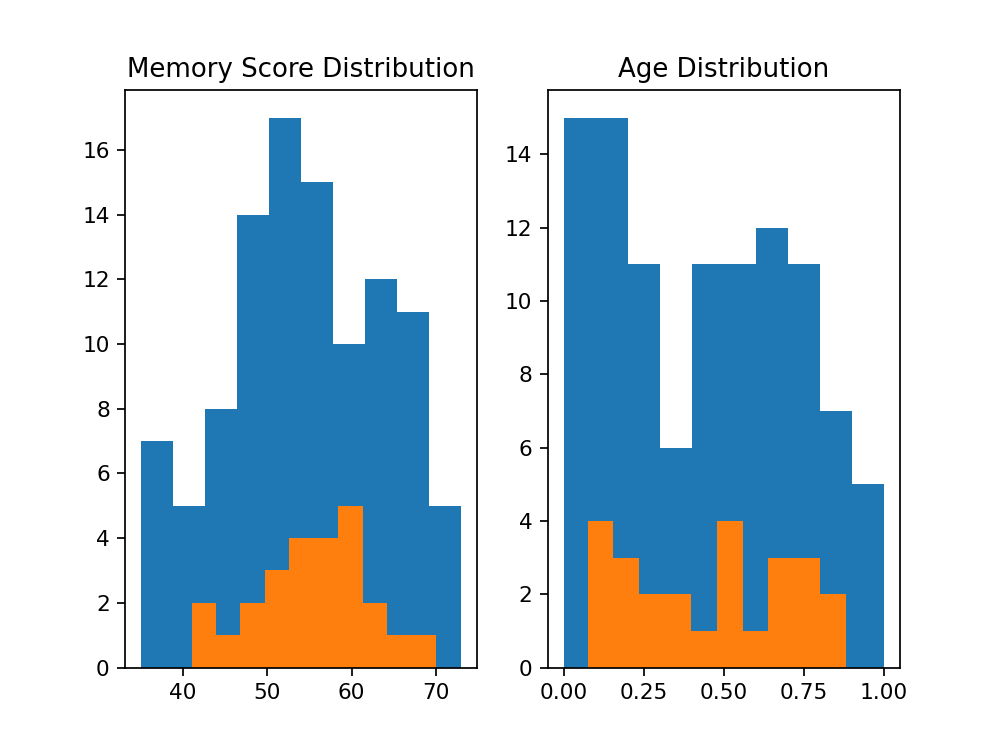

        Best MSE (across all inner validation folds): 72.70958189292722
        Best parameters: {'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}

        MSE (on outer training set) 54.45482327428306
        RMSE (on outer training set) 7.379351141820198
        MAE (on outer training set) 6.229502868110332
        R2 (on outer training set) 0.40286695973177367
        Correlation between Predicted and actual values (on outer test set) 0.6367777181376466

        MSE (on outer test set) 36.58691695219961
        RMSE (on outer test set) 6.048712007708716
        MAE (on outer test set) 4.906723601277955
        R2 (on outer test set) 0.21998829665968211
        Correlation between Predicted and actual values (on outer test set) 0.5093653539146328

    Average performance across all outer test sets:
        MSE 66.54 +/- 15.42
        RMSE 8.09 +/- 1.04
        MAE 6.67 +/- 0.97
        R2 0.18 +/- 0.07
        Correlation 0.47 +/- 0.07


In [8]:
# Empty list to store evaluation metrics
outer_train_mae = []
outer_train_mse = []
outer_train_rmse = []
outer_train_corelation = []
outer_train_r2 = []

outer_test_mae = []
outer_test_mse = []
outer_test_rmse = []
outer_test_corelation = []
outer_test_r2 = []

importance_train_df = pd.DataFrame()

importance_test_df = pd.DataFrame()

feature_names = ['Age','Sex', 'EduYears', 'Smoker', 'High_BP', 'COMT', 'BDNF2', 'ApoE4',
                 'L_HH_Total', 'R_HH_Total', 'L_HB_Total', 'R_HB_Total', 'L_HT_Total', 'R_HT_Total',
                 'L_DG_Total', 'R_DG_Total',
                 'L_CA_Total', 'R_CA_Total',
                 'L_Sub_Total', 'R_Sub_Total',
                 'L_HH_CA', 'R_HH_CA', 'L_HB_CA', 'R_HB_CA', 'L_HT_CA', 'R_HT_CA', 
                 'L_HH_DG', 'R_HH_DG', 'L_HB_DG', 'R_HB_DG', 'L_HT_DG', 'R_HT_DG',
                 'L_HH_Sub', 'R_HH_Sub', 'L_HB_Sub', 'R_HB_Sub', 'L_HT_Sub', 'R_HT_Sub']
target = ['CVLT_Imm_Total']

# Feature Scaling
scaler = MinMaxScaler()
df[feature_names] = scaler.fit_transform(df[feature_names])

# configure the cross-validation procedure
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

#fold counter
fold_no = 1

# Loop through each outer CV fold
for train_index_outer, test_index_outer in outer_cv.split(df, df.grp):
    train_set = df.loc[train_index_outer,:]
    test_set = df.loc[test_index_outer,:]

    X_train = train_set[feature_names]
    y_train = train_set[target]
    X_test = test_set[feature_names]
    y_test = test_set[target]
    
        
    print("\n Results for outer loop fold ", fold_no)
    fold_no = fold_no+1
        
    
    #Print out memory performance to ensure similar distribution across folds
    plt.figure()
    plt.subplot(1, 2, 1) 
    plt.hist(y_train, bins=10)
    plt.hist(y_test, bins=10)
    plt.title("Memory Score Distribution")
    
    plt.subplot(1, 2, 2)
    plt.hist(X_train.Age, bins=10)
    plt.hist(X_test.Age, bins=10)
    plt.title("Age Distribution")
    plt.show()
    
    #Apply grid search with CV=3 on outer train_set (this is hyperparameter tuning process within the inner loop)
    search.fit(X = X_train, y = y_train) # run inner loop hyperparam tuning

    print('        Best MSE (across all inner validation folds):', abs(search.best_score_))
    print('        Best parameters:', search.best_params_)
    
    #Best model based on grid search
    best_model = search.best_estimator_
   
    #Inner Train set performance
    #This is to compare with performance on the test set and identify fitting issues
    #Predict train set
    y_train_hat = best_model.predict(X_train)
    
    #MSE
    mse_train = mean_squared_error(y_train, y_train_hat)
    outer_train_mse.append(mse_train)
    print('\n        MSE (on outer training set)', mse_train)
    
    #RMSE
    rmse_train = np.sqrt(mse_train)
    outer_train_rmse.append(rmse_train)
    print('        RMSE (on outer training set)', (outer_train_rmse[-1]))

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_hat)
    outer_train_mae.append(mae_train)          
    print('        MAE (on outer training set)', (outer_train_mae[-1]))
         
    # R2
    r2_train = r2_score(y_train, y_train_hat)
    outer_train_r2.append(r2_train)    
    print('        R2 (on outer training set)', (outer_train_r2[-1]))
    
    #Correlation between true vs predicted
    y_train_array = np.array(y_train).reshape(1,len(y_train))
    y_train_hat_array = pd.DataFrame(y_train_hat)
    y_train_hat_array = np.array(y_train_hat_array).reshape(1,len(y_train_hat))
    corelation_true_pred_train = np.corrcoef(y_train_array, y_train_hat_array)[0,1]
    outer_train_corelation.append(corelation_true_pred_train)          
    print('        Correlation between Predicted and actual values (on outer test set)', (outer_train_corelation[-1]))
    
    
    ######## EVALUATE ON OUTER TEST SET ########
    #Predict y_test based on best model
    y_test_hat = best_model.predict(X_test)
    
    # Calculate evaluation metrics using best-tuned model on the outer val_set  
    #MSE
    mse_test = mean_squared_error(y_test, y_test_hat)
    outer_test_mse.append(mse_test)
    print('\n        MSE (on outer test set)', (outer_test_mse[-1]))
    
    #RMSE
    rmse_test = np.sqrt(mse_test)
    outer_test_rmse.append(rmse_test)
    print('        RMSE (on outer test set)', (outer_test_rmse[-1]))

    # MAE
    mae_test = mean_absolute_error(y_test, y_test_hat)
    outer_test_mae.append(mae_test)          
    print('        MAE (on outer test set)', (outer_test_mae[-1]))
         
    # R2
    r2_test = r2_score(y_test, y_test_hat)
    outer_test_r2.append(r2_test)    
    print('        R2 (on outer test set)', (outer_test_r2[-1]))
    
    #Correlation between true vs predicted
    y_test_array = np.array(y_test).reshape(1,len(y_test))
    y_test_hat_array = pd.DataFrame(y_test_hat)
    y_test_hat_array = np.array(y_test_hat_array).reshape(1,len(y_test_hat))
    corelation_true_pred = np.corrcoef(y_test_array, y_test_hat_array)[0,1]
    outer_test_corelation.append(corelation_true_pred)          
    print('        Correlation between Predicted and actual values (on outer test set)', (outer_test_corelation[-1]))
    
    
    ######## Feature importance #########
    ### Training set     
            
    # perform permutation importance
    results_train = permutation_importance(best_model, 
                                           X_train, y_train, random_state = 42, scoring = 'neg_mean_squared_error')

    # get importance
    importance_train = results_train.importances_mean

    #Create df column for importanct
    column_name = 'Feature Importance '+ str(fold_no-1)
    importance_train_df[column_name] = importance_train
    
    ### Test set     
            
    # perform permutation importance
    results_test = permutation_importance(best_model, 
                                          X_test, y_test, random_state = 42, scoring = 'neg_mean_squared_error')

    # get importance
    importance_test = results_test.importances_mean

    #Create df column for importanct
    column_name = 'Feature Importance '+ str(fold_no-1)
    importance_test_df[column_name] = importance_test
    
    
# Print evaluation metrics across all outer loop folds
print('\n    Average performance across all outer test sets:')
print('        MSE %.2f +/- %.2f'% (np.mean(outer_test_mse), np.std(outer_test_mse)))
print('        RMSE %.2f +/- %.2f'% (np.mean(outer_test_rmse), np.std(outer_test_rmse)))
print('        MAE %.2f +/- %.2f'% (np.mean(outer_test_mae), np.std(outer_test_mae)))
print('        R2 %.2f +/- %.2f'% (np.mean(outer_test_r2), np.std(outer_test_r2)))
print('        Correlation %.2f +/- %.2f'% (np.mean(outer_test_corelation), np.std(outer_test_corelation)))

### Feature importance (outer training sets)

In [9]:
#Feature Importance Dataframe

importance_train_df = importance_train_df.set_index(X_test.columns)
importance_train_df["Mean Importance"] = importance_train_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].mean(axis=1)
importance_train_df["SD Importance"] = importance_train_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].std(axis=1)

In [10]:
importance_train_df

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Importance,SD Importance
Age,13.251143,22.645168,10.975318,16.155605,20.868313,16.779109,4.940939
Sex,19.638274,23.954352,23.892668,10.236170,18.814341,19.307161,5.595950
EduYears,0.476138,3.476815,3.108767,0.885301,1.897504,1.968905,1.321053
Smoker,0.000000,0.000000,0.242431,0.298952,0.000000,0.108277,0.149604
High_BP,0.107659,2.211640,0.127939,-0.311795,0.067588,0.440606,1.006283
COMT,0.301870,1.576433,0.595000,1.911509,1.073531,1.091669,0.666694
BDNF2,1.917855,3.369733,0.759722,0.908920,0.868030,1.564852,1.112008
ApoE4,0.122576,3.852362,0.302012,0.158400,0.584171,1.003904,1.602666
L_HH_Total,0.054271,-0.077308,0.007055,-0.005973,-0.093150,-0.023021,0.061307
R_HH_Total,0.750442,0.354154,0.826756,0.387213,0.457836,0.555281,0.217934


In [11]:
#Sort by mean importance
importance_train_df = importance_train_df.sort_values(by=["Mean Importance"], ascending = False)
importance_train_df[0:10]

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Importance,SD Importance
Sex,19.638274,23.954352,23.892668,10.236170,18.814341,19.307161,5.595950
Age,13.251143,22.645168,10.975318,16.155605,20.868313,16.779109,4.940939
EduYears,0.476138,3.476815,3.108767,0.885301,1.897504,1.968905,1.321053
BDNF2,1.917855,3.369733,0.759722,0.908920,0.868030,1.564852,1.112008
COMT,0.301870,1.576433,0.595000,1.911509,1.073531,1.091669,0.666694
ApoE4,0.122576,3.852362,0.302012,0.158400,0.584171,1.003904,1.602666
R_HH_DG,0.927123,0.985880,0.522941,1.054845,1.089633,0.916084,0.228544
R_HT_DG,0.630610,0.903394,1.494448,0.332904,1.052545,0.882780,0.438559
L_HT_CA,-0.226640,1.159105,1.605730,0.294009,0.689883,0.704418,0.716697
L_HB_Sub,-0.006237,0.492309,1.614598,1.000399,0.042456,0.628705,0.684760


<IPython.core.display.Javascript object>


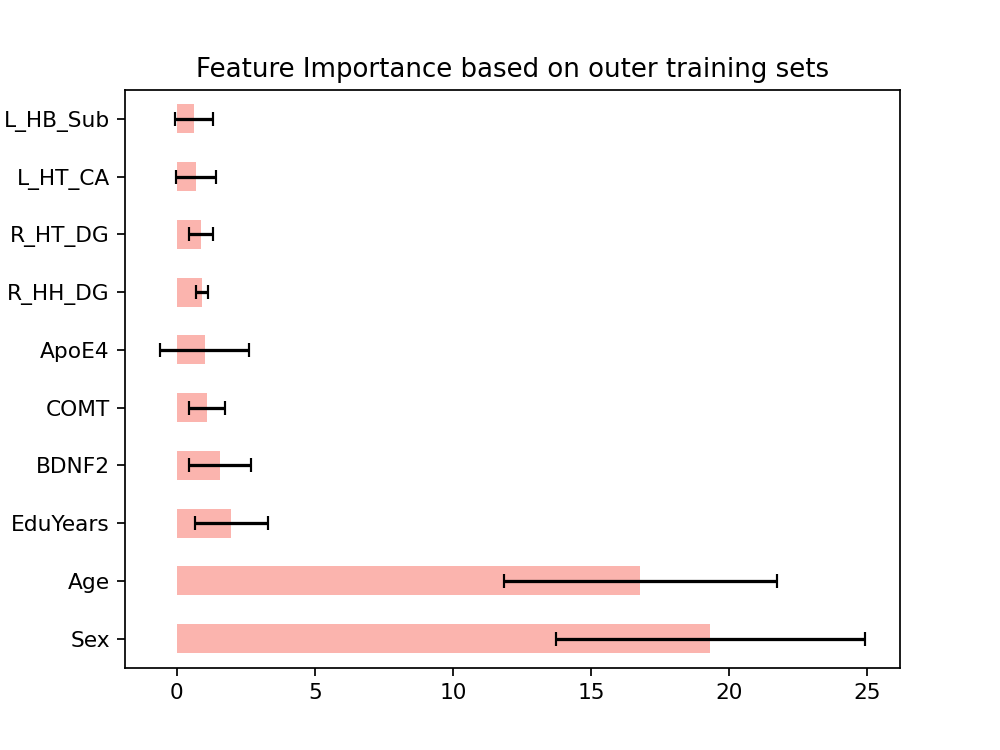

In [12]:
s = (pd.Series(importance_train_df["Mean Importance"], index=X_train.columns)).nlargest(10)
err = importance_train_df["SD Importance"][0:10]

plt.figure()
s.plot(kind='barh', xerr=err, capsize=3, colormap = 'Pastel1')
plt.title('Feature Importance based on outer training sets')
plt.show()

## Feature importance (outer test sets)

In [13]:
#Feature Importance Dataframe

importance_test_df = importance_test_df.set_index(X_test.columns)
importance_test_df["Mean Importance"] = importance_test_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].mean(axis=1)
importance_test_df["SD Importance"] = importance_test_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].std(axis=1)

In [14]:
importance_test_df

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Importance,SD Importance
Age,31.555528,21.121759,30.240537,2.195686,7.716423,18.565987,13.202794
Sex,18.697216,21.023328,13.595817,27.098745,13.836739,18.850369,5.601958
EduYears,2.226456,-3.964629,5.304538,1.307625,8.202143,2.615226,4.571693
Smoker,0.000000,0.000000,0.000000,0.789605,0.000000,0.157921,0.353122
High_BP,-0.868426,-2.300729,0.556220,0.347080,-0.808071,-0.614785,1.144611
COMT,2.812533,-0.156220,2.244233,-0.051485,-1.482180,0.673376,1.796083
BDNF2,-0.876725,1.511955,1.378438,1.884408,1.528563,1.085328,1.112718
ApoE4,4.737305,-8.382201,0.591870,0.692557,1.668127,-0.138469,4.904591
L_HH_Total,-1.040192,-0.176369,-0.058228,-0.495109,-0.357184,-0.425416,0.382202
R_HH_Total,1.125704,0.266542,-3.382627,-0.322853,1.415995,-0.179448,1.918899


In [15]:
#Sort by mean importance
importance_test_df = importance_test_df.sort_values(by=["Mean Importance"], ascending = False)
importance_test_df[0:10]

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Importance,SD Importance
Sex,18.697216,21.023328,13.595817,27.098745,13.836739,18.850369,5.601958
Age,31.555528,21.121759,30.240537,2.195686,7.716423,18.565987,13.202794
EduYears,2.226456,-3.964629,5.304538,1.307625,8.202143,2.615226,4.571693
R_HH_DG,1.203548,3.158532,0.182715,-0.201711,2.672643,1.403145,1.483059
R_HT_DG,0.184227,-0.074594,3.902008,-1.285458,2.879493,1.121135,2.175105
BDNF2,-0.876725,1.511955,1.378438,1.884408,1.528563,1.085328,1.112718
L_HB_Sub,2.628919,3.378691,-0.405154,0.454017,-0.980581,1.015179,1.904314
COMT,2.812533,-0.156220,2.244233,-0.051485,-1.482180,0.673376,1.796083
R_HT_Sub,-0.805898,-0.487629,0.524119,5.480983,-2.200820,0.502151,2.948981
R_HT_Total,0.187621,-0.264962,1.908542,-1.427979,1.744382,0.429521,1.406013


<IPython.core.display.Javascript object>


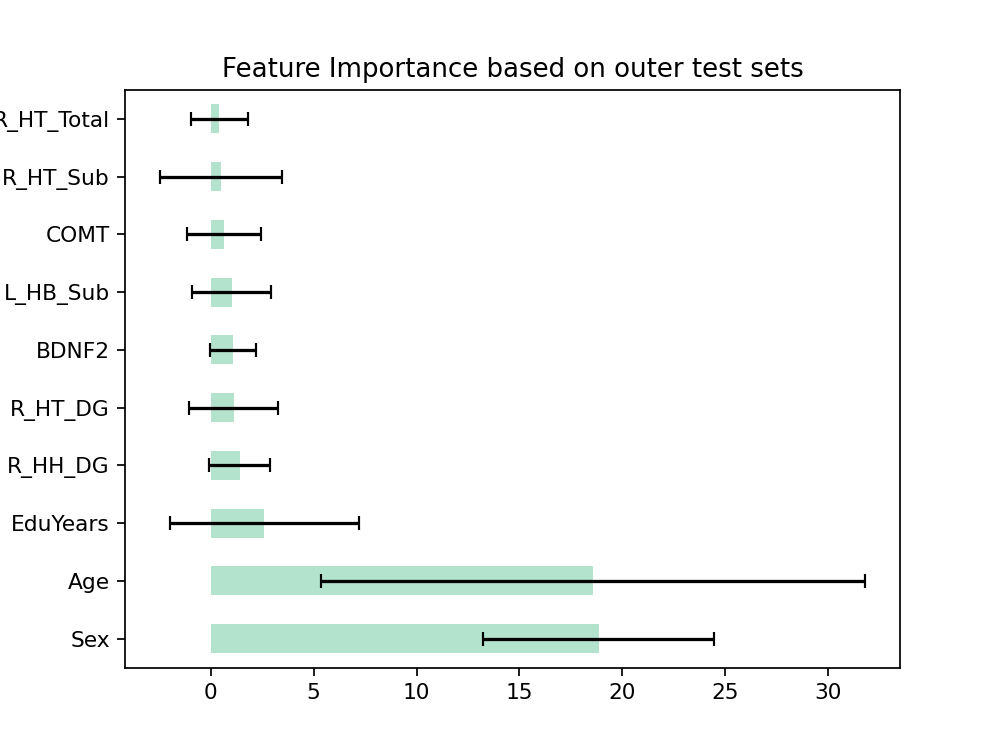

In [16]:
s = (pd.Series(importance_test_df["Mean Importance"], index=X_test.columns)).nlargest(10)
err = importance_test_df["SD Importance"][0:10]

plt.figure()
s.plot(kind='barh', xerr=err, capsize=3, colormap = 'Pastel2')
plt.title('Feature Importance based on outer test sets')
plt.show()

# Predicting Long-Delayed Free Recall

In [17]:
# Empty list to store evaluation metrics
outer_train_mae = []
outer_train_mse = []
outer_train_rmse = []
outer_train_corelation = []
outer_train_r2 = []

outer_test_mae = []
outer_test_mse = []
outer_test_rmse = []
outer_test_corelation = []
outer_test_r2 = []

importance_train_df = pd.DataFrame()

importance_test_df = pd.DataFrame()

feature_names = ['Age','Sex', 'EduYears', 'Smoker', 'High_BP', 'COMT', 'BDNF2', 'ApoE4',
                 'L_HH_Total', 'R_HH_Total', 'L_HB_Total', 'R_HB_Total', 'L_HT_Total', 'R_HT_Total',
                 'L_DG_Total', 'R_DG_Total',
                 'L_CA_Total', 'R_CA_Total',
                 'L_Sub_Total', 'R_Sub_Total',
                 'L_HH_CA', 'R_HH_CA', 'L_HB_CA', 'R_HB_CA', 'L_HT_CA', 'R_HT_CA', 
                 'L_HH_DG', 'R_HH_DG', 'L_HB_DG', 'R_HB_DG', 'L_HT_DG', 'R_HT_DG',
                 'L_HH_Sub', 'R_HH_Sub', 'L_HB_Sub', 'R_HB_Sub', 'L_HT_Sub', 'R_HT_Sub']
target = ['CVLT_DelR_LD_Free']

# Feature Scaling
scaler = MinMaxScaler()
df[feature_names] = scaler.fit_transform(df[feature_names])

# configure the cross-validation procedure
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 

#fold counter
fold_no = 1

# Loop through each outer CV fold
for train_index_outer, test_index_outer in outer_cv.split(df, df.grp):
    train_set = df.loc[train_index_outer,:]
    test_set = df.loc[test_index_outer,:]

    X_train = train_set[feature_names]
    y_train = train_set[target]
    X_test = test_set[feature_names]
    y_test = test_set[target]
    
        
    print("\n Results for outer loop fold ", fold_no)
    fold_no = fold_no+1
        
    
    #Print out memory performance to ensure similar distribution across folds
#    plt.figure()
#    plt.subplot(1, 2, 1) 
#    plt.hist(y_train, bins=10)
#    plt.hist(y_test, bins=10)
#    plt.title("Memory Score Distribution")
    
#    plt.subplot(1, 2, 2)
#    plt.hist(X_train.Age, bins=10)
#    plt.hist(X_test.Age, bins=10)
#    plt.title("Age Distribution")
#    plt.show()
    
    #Apply grid search with CV=3 on outer train_set (this is hyperparameter tuning process within the inner loop)
    search.fit(X = X_train, y = y_train) # run inner loop hyperparam tuning

    print('        Best MSE (across all inner validation folds):', abs(search.best_score_))
    print('        Best parameters:', search.best_params_)
    
    #Best model based on grid search
    best_model = search.best_estimator_
   
    #Inner Train set performance
    #This is to compare with performance on the test set and identify fitting issues
    #Predict train set
    y_train_hat = best_model.predict(X_train)
    
    #MSE
    mse_train = mean_squared_error(y_train, y_train_hat)
    outer_train_mse.append(mse_train)
    print('\n        MSE (on outer training set)', mse_train)
    
    #RMSE
    rmse_train = np.sqrt(mse_train)
    outer_train_rmse.append(rmse_train)
    print('        RMSE (on outer training set)', (outer_train_rmse[-1]))

    # MAE
    mae_train = mean_absolute_error(y_train, y_train_hat)
    outer_train_mae.append(mae_train)          
    print('        MAE (on outer training set)', (outer_train_mae[-1]))
         
    # R2
    r2_train = r2_score(y_train, y_train_hat)
    outer_train_r2.append(r2_train)    
    print('        R2 (on outer training set)', (outer_train_r2[-1]))
    
    #Correlation between true vs predicted
    y_train_array = np.array(y_train).reshape(1,len(y_train))
    y_train_hat_array = pd.DataFrame(y_train_hat)
    y_train_hat_array = np.array(y_train_hat_array).reshape(1,len(y_train_hat))
    corelation_true_pred_train = np.corrcoef(y_train_array, y_train_hat_array)[0,1]
    outer_train_corelation.append(corelation_true_pred_train)          
    print('        Correlation between Predicted and actual values (on outer test set)', (outer_train_corelation[-1]))
    
    
    ######## EVALUATE ON OUTER TEST SET ########
    #Predict y_test based on best model
    y_test_hat = best_model.predict(X_test)
    
    # Calculate evaluation metrics using best-tuned model on the outer val_set  
    #MSE
    mse_test = mean_squared_error(y_test, y_test_hat)
    outer_test_mse.append(mse_test)
    print('\n        MSE (on outer test set)', (outer_test_mse[-1]))
    
    #RMSE
    rmse_test = np.sqrt(mse_test)
    outer_test_rmse.append(rmse_test)
    print('        RMSE (on outer test set)', (outer_test_rmse[-1]))

    # MAE
    mae_test = mean_absolute_error(y_test, y_test_hat)
    outer_test_mae.append(mae_test)          
    print('        MAE (on outer test set)', (outer_test_mae[-1]))
         
    # R2
    r2_test = r2_score(y_test, y_test_hat)
    outer_test_r2.append(r2_test)    
    print('        R2 (on outer test set)', (outer_test_r2[-1]))
    
    #Correlation between true vs predicted
    y_test_array = np.array(y_test).reshape(1,len(y_test))
    y_test_hat_array = pd.DataFrame(y_test_hat)
    y_test_hat_array = np.array(y_test_hat_array).reshape(1,len(y_test_hat))
    corelation_true_pred = np.corrcoef(y_test_array, y_test_hat_array)[0,1]
    outer_test_corelation.append(corelation_true_pred)          
    print('        Correlation between Predicted and actual values (on outer test set)', (outer_test_corelation[-1]))
    
    
    ######## Feature importance #########
    ### Training set     
            
    # perform permutation importance
    results_train = permutation_importance(best_model, 
                                           X_train, y_train, random_state = 42, scoring = 'neg_mean_squared_error')

    # get importance
    importance_train = results_train.importances_mean

    #Create df column for importanct
    column_name = 'Feature Importance '+ str(fold_no-1)
    importance_train_df[column_name] = importance_train
    
    ### Test set     
            
    # perform permutation importance
    results_test = permutation_importance(best_model, 
                                          X_test, y_test, random_state = 42, scoring = 'neg_mean_squared_error')

    # get importance
    importance_test = results_test.importances_mean

    #Create df column for importanct
    column_name = 'Feature Importance '+ str(fold_no-1)
    importance_test_df[column_name] = importance_test
    
    
# Print evaluation metrics across all outer loop folds
print('\n    Average performance across all outer test sets:')
print('        MSE %.2f +/- %.2f'% (np.mean(outer_test_mse), np.std(outer_test_mse)))
print('        RMSE %.2f +/- %.2f'% (np.mean(outer_test_rmse), np.std(outer_test_rmse)))
print('        MAE %.2f +/- %.2f'% (np.mean(outer_test_mae), np.std(outer_test_mae)))
print('        R2 %.2f +/- %.2f'% (np.mean(outer_test_r2), np.std(outer_test_r2)))
print('        Correlation %.2f +/- %.2f'% (np.mean(outer_test_corelation), np.std(outer_test_corelation)))


 Results for outer loop fold  1
        Best MSE (across all inner validation folds): 5.8268235684812515
        Best parameters: {'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}

        MSE (on outer training set) 4.071933033829102
        RMSE (on outer training set) 2.017903127959591
        MAE (on outer training set) 1.6623298145860614
        R2 (on outer training set) 0.3790372361445933
        Correlation between Predicted and actual values (on outer test set) 0.6182158975521549

        MSE (on outer test set) 8.528006146003678
        RMSE (on outer test set) 2.9202750120500087
        MAE (on outer test set) 2.4491120652482095
        R2 (on outer test set) -0.1465656632256338
        Correlation between Predicted and actual values (on outer test set) 0.1712664599111675

 Results for outer loop fold  2
        Best MSE (across all inner validation folds): 5.910423219251961
        Best parameters: {'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

        MSE (on outer tra

### Feature Importance (training sets)

In [18]:
#Feature Importance Dataframe

importance_train_df = importance_train_df.set_index(X_test.columns)
importance_train_df["Mean Importance"] = importance_train_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].mean(axis=1)
importance_train_df["SD Importance"] = importance_train_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].std(axis=1)

#Sort by mean importance
importance_train_df = importance_train_df.sort_values(by=["Mean Importance"], ascending = False)
importance_train_df[0:10]

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Importance,SD Importance
Sex,2.467075,1.427698,1.265726,1.208577,0.720478,1.417911,0.643085
Age,1.354285,1.295450,0.497038,0.997628,0.572157,0.943312,0.397733
COMT,0.137927,0.143535,0.042696,0.120110,0.053426,0.099539,0.047932
High_BP,0.385788,0.000000,0.018602,0.000000,0.013684,0.083615,0.169122
BDNF2,0.133917,0.184595,0.017409,0.048506,0.032349,0.083355,0.072407
R_HH_DG,0.108619,0.056044,0.012937,0.090913,0.016736,0.057050,0.042948
ApoE4,-0.001077,0.245595,0.004188,0.015071,-0.015522,0.049651,0.110088
R_HT_DG,0.116916,0.050140,-0.005426,0.010838,0.056751,0.045844,0.047547
L_HT_Sub,0.174827,0.016550,0.005268,0.022921,0.000253,0.043964,0.073701
Smoker,0.000000,0.000000,0.186526,0.000000,0.001231,0.037551,0.083281


<IPython.core.display.Javascript object>


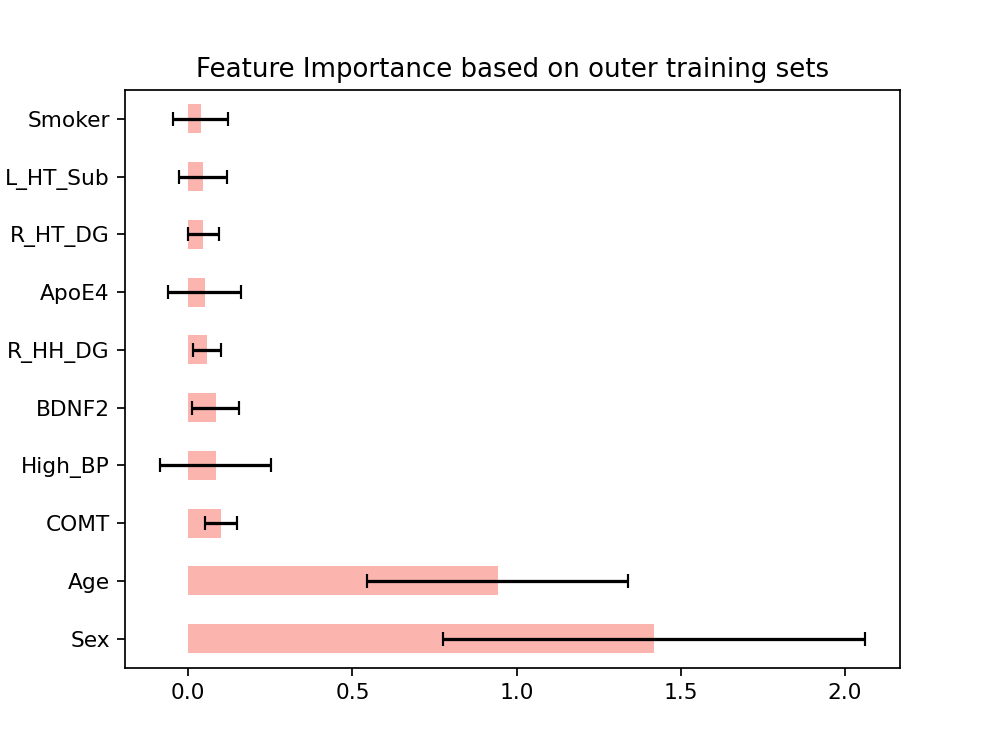

In [19]:
s = (pd.Series(importance_train_df["Mean Importance"], index=X_train.columns)).nlargest(10)
err = importance_train_df["SD Importance"][0:10]

plt.figure()
s.plot(kind='barh', xerr=err, capsize=3, colormap = 'Pastel1')
plt.title('Feature Importance based on outer training sets')
plt.show()

## Feature Importance (test sets)

In [20]:
#Feature Importance Dataframe

importance_test_df = importance_test_df.set_index(X_test.columns)
importance_test_df["Mean Importance"] = importance_test_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].mean(axis=1)
importance_test_df["SD Importance"] = importance_test_df[['Feature Importance 1', 'Feature Importance 2', 'Feature Importance 3', 
                 'Feature Importance 4', 'Feature Importance 5']].std(axis=1)

#Sort by mean importance
importance_test_df = importance_test_df.sort_values(by=["Mean Importance"], ascending = False)
importance_test_df[0:10]

,Feature Importance 1,Feature Importance 2,Feature Importance 3,Feature Importance 4,Feature Importance 5,Mean Importance,SD Importance
Sex,2.225981,2.356283,0.521347,2.037904,0.526090,1.533521,0.928743
Age,2.158238,0.988756,2.003455,-0.058212,0.324670,1.083381,0.986114
COMT,0.099019,-0.155347,0.218242,0.271093,0.000146,0.086631,0.171416
R_HH_DG,0.031383,0.255660,0.024260,0.041072,0.046397,0.079754,0.098706
R_HH_Total,0.220023,-0.003303,0.009089,0.057730,0.078305,0.072369,0.089137
R_HH_CA,0.242273,-0.027834,0.010724,0.052610,0.035148,0.062584,0.104887
L_HB_DG,0.336444,0.052857,0.010223,-0.012516,-0.182669,0.040868,0.187927
R_CA_Total,0.081075,-0.042204,0.021984,0.040786,0.056642,0.031657,0.046634
EduYears,-0.057578,-0.005393,0.189181,0.014361,0.001965,0.028507,0.093915
R_HH_Sub,0.041504,-0.017933,0.084269,0.002061,0.027141,0.027409,0.039148


<IPython.core.display.Javascript object>


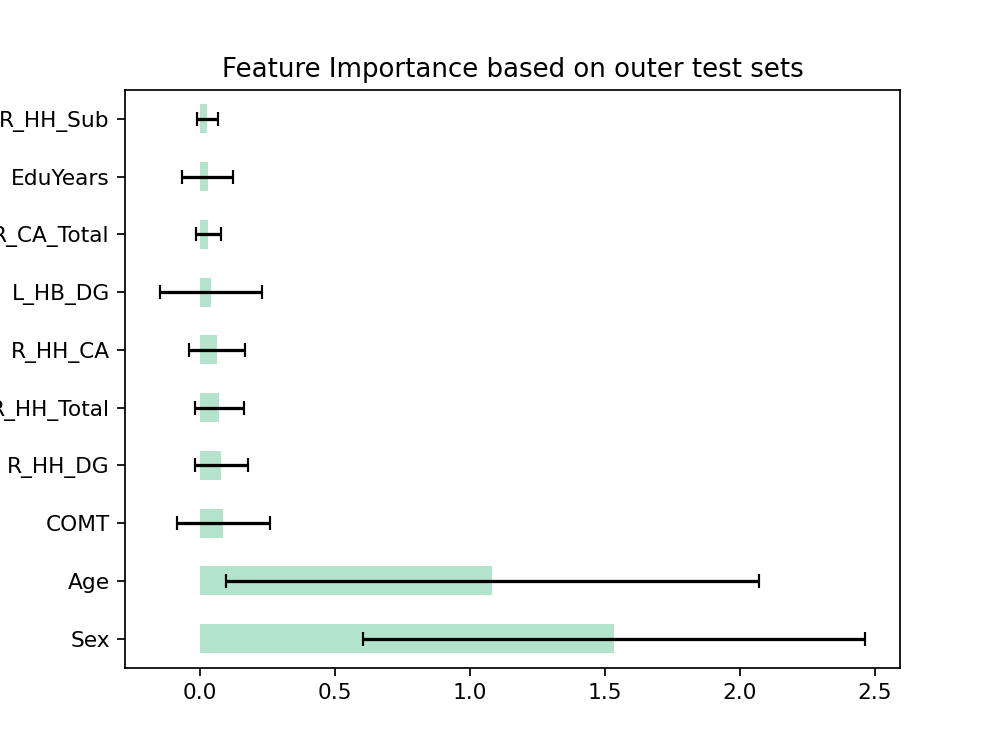

In [21]:
s = (pd.Series(importance_test_df["Mean Importance"], index=X_test.columns)).nlargest(10)
err = importance_test_df["SD Importance"][0:10]

plt.figure()
s.plot(kind='barh', xerr=err, capsize=3, colormap = 'Pastel2')
plt.title('Feature Importance based on outer test sets')
plt.show()